Step 0: Importing Relevant Packages (0%)

In [61]:
# Web Scraping Libraries
from bs4 import BeautifulSoup  # for scraping
import requests  # for sending HTTP requests
# Data Processing Libraries
import csv
import re
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

Step 1: Crawl a Real World Data Set (2%)

In [62]:
# Covid Data
url = "https://www.worldometers.info/coronavirus/#main_table"  # Web address of data
response = requests.get(url)  # Performing a get request for the data at the url location
soup_object = BeautifulSoup(response.content)  # Parsing the request response to create a soup_object that can be searched for a table
covid_table = soup_object.find("table")  # Searching the soup_object for a table

with open("Live_Covid_Data.csv", "w", newline="") as csv_file:  # Opening a CSV file to be written into
    writer = csv.writer(csv_file)  # Defining the writer as a csv writer that writes to the opened file

    for row in covid_table.find_all("tr"):  # Iterate through the rows of the table, "tr" points to a row in the table
        cells = row.find_all("td")  # Get the cells in the row, "td" points to a cell in the row

        if cells:  # If there are cells...
            values = [cell.text for cell in cells]  # Values is a list of values for each cell in the row of cells
            writer.writerow(values)  # Write the values to the CSV


Step 2: Data Preparation and Cleaning (5%)

In [77]:
# Creating list of column names
col_names = ["Country", "Total Cases", "New Cases", "Total Deaths", "New Deaths", "Total Recovered", "New Recovered", "Active Cases", "Critical Cases",
             "Total Cases / 1M People", "Total Deaths / 1M People", "Total Tests", "Total Tests / 1M People", "Population", "Continent", "One Case / n People",
             "One Death / n People", "One Test / n People", "New Cases / 1M People", "New Deaths / 1M People", "Active Cases / 1M People"]

# Reading the csv to a dataframe with the column names specified, encoding with "latin-1" to get around "utf-8" decoding issue.
df = pd.read_csv("Live_Covid_Data.csv", names=col_names, header=None, encoding="latin-1")

# Tidying up the names of the continent by removing the "\n"'s on it, i.e. "\nNorth America\n"
old_continent_list = df.iloc[0:7]["Country"].tolist()  # Locating the continent names and putting them into a list
new_continent_list = []  # Defining a list for the formatted continent names

for old_continent in old_continent_list:  # Iterate through current continent names
     new_continent = "Antarctica" if old_continent == "\n\n" else old_continent.replace("\n", "")  # Removing \n from continent names/identifying Antarctica
     if new_continent == "Oceania":  # In "Continent" column countries are assigned Australia/Oceania not just Oceania
         new_continent = "Australia/Oceania"  # Renaming continent
     new_continent_list.append(new_continent)  # Addding the renamed continenet to the new list

# Changing the index to the name of the Country/Continent
df.set_index("Country", inplace=True)  # inplace=True updates the original datafram immediately

# Changing the index name to the re-formatted continents. set_value has been depricated, also before setting the index as Country the continent rows had
# an index of NaN so at[row, col] couldn't be used to assign values either. Therefore, application of the reformatted names had to after set_index was done.
n = 0
for new_continent in new_continent_list:  # Iterate through the new continent names
    df.rename(index={old_continent_list[n]: new_continent}, inplace=True)  # Replace the old continent name with corresponding new continent name
    n += 1

# Moving country continent and population to first/second column as it is important for comparison to total cases etc
pop_col = df.pop("Continent")
df.insert(0, "Continent", pop_col)
pop_col = df.pop("Population")  # Removes the column from DF while saving it to a variable
df.insert(1, "Population", pop_col)  # Replacing the column in first position using previously assigned variable
pop_col = df.pop("Total Tests")
df.insert(5, "Total Tests", pop_col)

# Removing non-ccountries/non-territories from the DF
drop_list = ["Diamond Princess", "MS Zaandam", "Total:"]  # List of unwanted non-countries/non-territories
for item in drop_list:  # Iterate through list
    df.drop(index=item, axis=0, inplace=True)  # Permanently delete the corresponding row in place

# Calculating the population of each continent and the world
global_population = 0  # Defining global population as 0
for continent in new_continent_list:  # iterate through the continents
    # If a row has continent "continent" and is not the row for the continent itself, population is added to the corresponding list
    population_list = df.loc[(df["Continent"] == continent) & (df.index != continent), "Population"].tolist()
    continent_population = 0  # Defining the continent's population as 0

    for population in population_list:  # Iterate through all populations in the list
        new_population = re.sub(",", "", population)  # Removing the commas from the strings seperating 1000's
        continent_population += int(new_population)  # Adding the population to the continent populatuon

    global_population += continent_population  # Adding the continent population to the global population
    df.at[continent, "Population"] = continent_population  # Replacing the continents NaN population with the calculated population
df.at["World", "Population"] = global_population  # Replacing the world's NaN population with the calculated population

# Dropping Antarctica as its data is not useful
df.drop(index="Antarctica", axis=0, inplace=True)

# Handling missing values
df = df.replace(r"^\s*$", np.nan, regex=True)
df

# Remove commas from all columns and convert all columns to floats while avoiding non-numeric data
df = df.replace(",", "", regex=True)  # Removing commas from entire dataframe, regex=True automates searching and replacing
df
for column in df:  # Iterate through all columns in the dataframe
    try:  # Try the following experssion:
        df[column] = df[column].astype(float)  # Convert the column to floats
    except ValueError:  # If this error is caused, raise an exception for the Nan/string value
        pass  # Skip the conversion if the column contains non-numeric data

# Dropping columns with the format "New..." as "New" is ambiguous and not described on the website, they also contain a lot of NaN.
for column in df:
    if "New" in column:
        df.drop(columns=column, inplace=True)

# Calculating the total tests taken in each continent
global_total_tests = 0  # Defining the global total as 0
for continent in new_continent_list[:-1]:  # Iterating through continents, except antarctica
    continent_total_tests = 0  # Defining the continent total as 0
    test_list = df.loc[(df["Continent"] == continent) & (df.index != continent), "Total Tests"].tolist()  # Adding all test numbers to a list
    clean_test_list = [x for x in test_list if (math.isnan(x) == False)]  # Removing nan values from the list
    continent_total_tests = sum(clean_test_list)  # Summing all the values in the list
    global_total_tests += continent_total_tests  # Adding the continent total to the global total
    df.at[continent, "Total Tests"] = continent_total_tests  # Reassigning the continent total tests value to new calculated value
df.at["World", "Total Tests"] = global_total_tests  # Reassign global test total after for loop has completed
df
# Recalculating X/1M based on the live data from other columns where x = Total Cases, Total Deaths, Total Tests, Active Cases
for column in df:  # Iterate through columns in the DF
    if "1M People" in column:  # Checking if the column is a target for recalculation
        reduced_column = column.replace(" / 1M People", "")  # Formulating the column from which x/1M column will be calculated
        df[column] = (df[reduced_column] / df["Population"]) * 1000000  # Recalculating column

# Recalculating how many people there where per one case/death/test
df["One Case / n People"] = df["Population"] / df["Total Cases"]
df["One Death / n People"] = df["Population"] / df["Total Deaths"]
df["One Test / n People"] = df["Population"] / df["Total Tests"]

df.loc["USA":]

,Continent,Population,Total Cases,Total Deaths,Total Tests,Total Recovered,Active Cases,Critical Cases,Total Cases / 1M People,Total Deaths / 1M People,Total Tests / 1M People,One Case / n People,One Death / n People,One Test / n People,Active Cases / 1M People
Country,,,,,,,,,,,,,,,
USA,North America,3.348053e+08,102692125.0,1118490.0,1.153934e+09,99620490.0,1953145.0,4597.0,306721.950066,3340.718034,3.446583e+06,3.260282,299.336846,0.290142,5833.674619
India,Asia,1.406632e+09,44680261.0,530707.0,9.109238e+08,44145667.0,3887.0,698.0,31764.006588,377.289216,6.475922e+05,31.482175,2650.486570,1.544182,2.763339
France,Europe,6.558452e+07,39356184.0,162377.0,2.714902e+08,38520768.0,673039.0,869.0,600083.452622,2475.843460,4.139547e+06,1.666435,403.902757,0.241572,10262.162787
Germany,Europe,8.388360e+07,37410650.0,161714.0,1.223324e+08,36710000.0,538936.0,1406.0,445982.907075,1927.838191,1.458359e+06,2.242238,518.715733,0.685702,6424.808016
Brazil,South America,2.153536e+08,36371609.0,694032.0,6.377617e+07,35081933.0,595644.0,8318.0,168892.510653,3222.755610,2.961463e+05,5.920926,310.293463,3.376710,2765.888378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Niue,Australia/Oceania,1.622000e+03,575.0,NaN,NaN,392.0,183.0,1.0,354500.616523,NaN,NaN,2.820870,NaN,NaN,112823.674476
Vatican City,Europe,7.990000e+02,29.0,NaN,NaN,29.0,0.0,NaN,36295.369212,NaN,NaN,27.551724,NaN,NaN,0.000000
Western Sahara,Africa,6.261610e+05,10.0,1.0,NaN,9.0,0.0,NaN,15.970334,1.597033,NaN,62616.100000,626161.000000,NaN,0.000000


In [92]:
# Adding Wikipedia GDP Data to DF
wiki_url = "https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)"  # Web address of data
wiki_response = requests.get(wiki_url)  # Performing a get request for the data at the url location
wiki_soup = BeautifulSoup(wiki_response.text, "lxml")  # Parsing the request response to create a soup_object that can be searched for a table
wiki_table = wiki_soup.find("table", {"class": "wikitable"})  # Searching the soup object for a table of specifc class


rows = wiki_table.find_all("tr")  # Find all the rows in the table
wiki_data = []  # Create an empty list to store the data

for row in rows:  # Iterate through the rows of the table, "tr" points to a row in the table
    cells = row.find_all("td")  # Get the cells in the row, "td" points to a cell in the row
    row_data = []  # Create an empty list to store the row data
    for cell in cells:  # Iterate through all cells in the current row
        row_data.append(cell.text)  # Append the cell data to the row data list
    wiki_data.append(row_data)  # Append the row to the table data list

wiki_df = pd.DataFrame(wiki_data)  # Convert the list to a df
wiki_col_names = ["Country", "UN Region", "IMF GDP Estimate", "Year", "World Bank GDP Estimate", "Year", "UN GDP Estimate", "Year"]
wiki_df.columns = wiki_col_names  # Renaming the columns

wiki_df = wiki_df.iloc[3:]  # Removing the top three rows as they contained unecessary data
wiki_df.set_index("Country", inplace=True)

new_wiki_df_index_list = ['USA', 'China', 'Japan', 'Germany', 'India', 'UK', 'France', 'Canada', 'Russia', 'Italy', 'Iran', 'Brazil', 'S. Korea', 'Australia', 'Mexico', 'Spain', 'Indonesia', 'Saudi Arabia', 'Netherlands', 'Turkey', 'Taiwan', 'Switzerland', 'Poland', 'Argentina', 'Sweden', 'Belgium', 'Thailand', 'Israel', 'Ireland', 'Norway', 'Nigeria', 'UAE', 'Egypt', 'Austria', 'Bangladesh', 'Malaysia', 'Singapore', 'Vietnam', 'South Africa', 'Philippines', 'Denmark', 'Pakistan', 'Hong Kong', 'Colombia', 'Chile', 'Romania', 'Czechia', 'Iraq', 'Finland', 'Portugal', 'New Zealand', 'Peru', 'Kazakhstan', 'Greece', 'Qatar', 'Ukraine', 'Algeria', 'Hungary', 'Kuwait', 'Morocco', 'Angola', 'Puerto Rico', 'Ecuador', 'Kenya', 'Slovakia', 'Dominican Republic', 'Ethiopia', 'Oman', 'Cuba', 'Guatemala', 'Bulgaria', 'Luxembourg', 'Venezuela', 'Belarus', 'Uzbekistan', 'Tanzania', 'Ghana', 'Turkmenistan', 'Sri Lanka', 'Uruguay', 'Panama', 'Azerbaijan', 'Croatia', 'Ivory Coast', 'Costa Rica', 'Lithuania', 'DRC', 'Serbia', 'Slovenia', 'Myanmar', 'Uganda', 'Jordan', 'Tunisia', 'Cameroon', 'Bahrain', 'Bolivia', 'Sudan', 'Paraguay', 'Libya', 'Latvia', 'Estonia', 'Nepal', 'Zimbabwe', 'El Salvador', 'Papua New Guinea', 'Honduras', 'Trinidad and Tobago', 'Cambodia', 'Iceland', 'Yemen', 'Senegal', 'Zambia', 'Cyprus', 'Georgia', 'Bosnia and Herzegovina', 'Macao', 'Gabon', 'Haiti', 'Afghanistan', 'Guinea', 'Palestine', 'Brunei', 'Mali', 'Burkina Faso', 'Albania', 'Lebanon', 'Botswana', 'Mozambique', 'Armenia', 'Benin', 'Malta', 'Equatorial Guinea', 'Laos', 'Jamaica', 'North Korea', 'Mongolia', 'Nicaragua', 'Syria', 'Madagascar', 'Guyana', 'Niger', 'Congo', 'North Macedonia', 'Moldova', 'Chad', 'Bahamas', 'Namibia', 'Rwanda', 'Malawi', 'Mauritius', 'Mauritania', 'Tajikistan', 'Kyrgyzstan', 'New Caledonia', 'Kosovo', 'Somalia', 'Togo', 'Bermuda', 'Liechtenstein', 'Monaco', 'Cayman Islands', 'Montenegro', 'Maldives', 'Guam', 'Barbados', 'French Polynesia', 'Fiji', 'South Sudan', 'Eswatini', 'Sierra Leone', 'Liberia', 'Djibouti', 'Burundi', 'Aruba', 'Andorra', 'Greenland', 'Suriname', 'Bhutan', 'Belize', 'Lesotho', 'Curaçao', 'CAR', 'Timor-Leste', 'Eritrea', 'Gambia', 'Cabo Verde', 'Seychelles', 'Saint Lucia', 'Zanzibar', 'Antigua and Barbuda', 'Guinea-Bissau', 'San Marino', 'Solomon Islands', 'British Virgin Islands', 'Comoros', 'Grenada', 'Northern Mariana Islands', 'Saint Kitts and Nevis', 'Vanuatu', 'Saint Vincent and the Grenadines', 'Turks and Caicos', 'Sint Maarten', 'Samoa', 'American Samoa', 'Dominica', 'São Tomé and Príncipe', 'Tonga', 'Micronesia', 'Cook Islands', 'Marshall Islands', 'Anguilla', 'Palau', 'Kiribati', 'Nauru', 'Montserrat', 'Tuvalu']

wiki_df.index = new_wiki_df_index_list
wik_df = wiki_df.replace(",", "", regex=True, inplace=True)  # Removing commas from entire dataframe, regex=True automates searching and replacing
for column in wiki_df:  # Iterate through all columns in the dataframe
    try:  # Try the following experssion:
        wiki_df[column] = wiki_df[column].astype(float)  # Convert the column to floats
    except ValueError:  # If this error is caused, raise an exception for the Nan/string value
        pass  # Skip the conversion if the column contains non-numeric data

for country in new_wiki_df_index_list:  # Iterate through all countries in the list
    value = wiki_df.loc[country, "UN GDP Estimate"]  # Take the UN GDP estimate for that ccountry
    numeric_value = pd.to_numeric(value, errors="coerce")  # Convert the value to numeric
    if pd.isnull(numeric_value):  # If the value is not numeric
        wiki_df.at[country, "UN GDP Estimate"] = np.nan  # set its value to NaN
wiki_df = wiki_df.replace("2020\n", np.nan)

df["GDP (USD million)"] = wiki_df["UN GDP Estimate"]

global_GDP = 0  # Defining the global GDP as 0
for continent in new_continent_list[:-1]:  # Iterating through continents, except antarctica
    continent_GDP = 0  # Defining the continent GDP as 0
    GDP_list = df.loc[(df["Continent"] == continent) & (df.index != continent), "GDP (USD million)"].tolist()  # Adding all GDPs to a list
    clean_GDP_list = [float(x) for x in GDP_list if (math.isnan(float(x)) == False)]  # Removing nan values from the list
    continent_GDP = sum(clean_GDP_list)  # Summing all the values in the list
    global_GDP += continent_GDP  # Adding the continent GDP to the global GDP
    df.at[continent, "GDP (USD million)"] = continent_GDP  # Reassigning the continent GDP value to new calculated value
df.at["World", "GDP (USD million)"] = global_GDP

pop_col = df.pop("GDP (USD million)")
df.insert(1, "GDP (USD million)", pop_col)
df

,Continent,GDP (USD million),Population,Total Cases,Total Deaths,Total Tests,Total Recovered,Active Cases,Critical Cases,Total Cases / 1M People,Total Deaths / 1M People,Total Tests / 1M People,One Case / n People,One Death / n People,One Test / n People,Active Cases / 1M People
Country,,,,,,,,,,,,,,,,
North America,North America,24017824.0,5.981409e+08,121554756.0,1579477.0,1.289782e+09,116340111.0,3635168.0,9780.0,203220.934647,2640.643631,2.156317e+06,4.920753,378.695553,0.463754,6077.444132
Asia,Asia,32316202.0,4.711357e+09,207695835.0,1513575.0,2.350327e+09,193989901.0,12192359.0,13087.0,44084.081203,321.260959,4.988641e+05,22.683925,3112.734277,2.004554,2587.865781
Europe,Europe,20989044.0,7.475438e+08,243137295.0,1983065.0,2.808111e+09,237589218.0,3565012.0,7528.0,325248.210159,2652.774194,3.756450e+06,3.074575,376.963860,0.266209,4768.967148
South America,South America,2895547.0,4.376944e+08,67007414.0,1342267.0,2.410751e+08,64554374.0,1110773.0,10332.0,153091.763150,3066.675900,5.507839e+05,6.532030,326.085975,1.815594,2537.781820
Australia/Oceania,Australia/Oceania,1668576.0,4.347041e+07,13634018.0,23389.0,8.844953e+07,13343750.0,266879.0,151.0,313639.062233,538.044179,2.034707e+06,3.188378,1858.583437,0.491471,6139.325860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Niue,Australia/Oceania,NaN,1.622000e+03,575.0,NaN,NaN,392.0,183.0,1.0,354500.616523,NaN,NaN,2.820870,NaN,NaN,112823.674476
Vatican City,Europe,NaN,7.990000e+02,29.0,NaN,NaN,29.0,0.0,NaN,36295.369212,NaN,NaN,27.551724,NaN,NaN,0.000000
Western Sahara,Africa,NaN,6.261610e+05,10.0,1.0,NaN,9.0,0.0,NaN,15.970334,1.597033,NaN,62616.100000,626161.000000,NaN,0.000000


Step 3: Exploratory Data Analysis (8%)

In [93]:
# Defining the colour pallette for continents so colours are always consistent when plotting
colour_dict = dict({"North America": "tab:blue", "Asia": "tab:orange", "Europe": "tab:green",
                    "South America": "tab:red", "Australia/Oceania": "tab:purple", "Africa": "tab:brown"})
# Displaying descriptive statistics for countries
df.loc["USA":].describe()  # Dont want continent totals included as these are just totals of other countries

,Population,Total Cases,Total Deaths,Total Tests,Total Recovered,Active Cases,Critical Cases,Total Cases / 1M People,Total Deaths / 1M People,Total Tests / 1M People,One Case / n People,One Death / n People,One Test / n People,Active Cases / 1M People
count,2.290000e+02,2.290000e+02,2.230000e+02,2.130000e+02,2.080000e+02,2.100000e+02,139.000000,229.000000,223.000000,2.130000e+02,229.000000,223.000000,213.000000,210.000000
mean,3.469404e+07,2.907302e+06,3.004537e+04,3.233608e+07,2.975462e+06,9.363030e+04,300.115108,191927.773575,1227.810595,2.112360e+06,406.460974,14568.330330,10.783493,14948.601537
std,1.386374e+08,9.368302e+06,1.049044e+05,1.172240e+08,9.398312e+06,5.995453e+05,996.004111,192741.525571,1266.579239,3.598780e+06,4148.215317,57234.721323,26.761398,50895.148860
min,7.990000e+02,5.000000e+00,1.000000e+00,7.850000e+03,2.000000e+00,0.000000e+00,1.000000,15.970334,1.597033,5.090634e+03,1.420538,154.337016,0.044308,0.000000
25%,4.454310e+05,2.537500e+04,2.250000e+02,3.478150e+05,2.304150e+04,1.150000e+02,4.500000,17077.190566,157.534006,1.865962e+05,3.210483,505.535822,0.409986,44.660786
50%,5.797805e+06,2.076540e+05,2.230000e+03,2.213831e+06,2.425435e+05,1.323000e+03,20.000000,123974.876715,787.918582,8.845931e+05,8.066150,1269.166667,1.130463,549.766770
75%,2.210284e+07,1.292224e+06,1.484600e+04,1.292916e+07,1.485393e+06,1.454450e+04,102.000000,311479.654304,1978.117711,2.439107e+06,58.557641,6356.462575,5.359166,3181.792812
max,1.448471e+09,1.026921e+08,1.118490e+06,1.153934e+09,9.962049e+07,8.244223e+06,8318.000000,703958.726870,6479.327048,2.256922e+07,62616.100000,626161.000000,196.439191,340116.235861


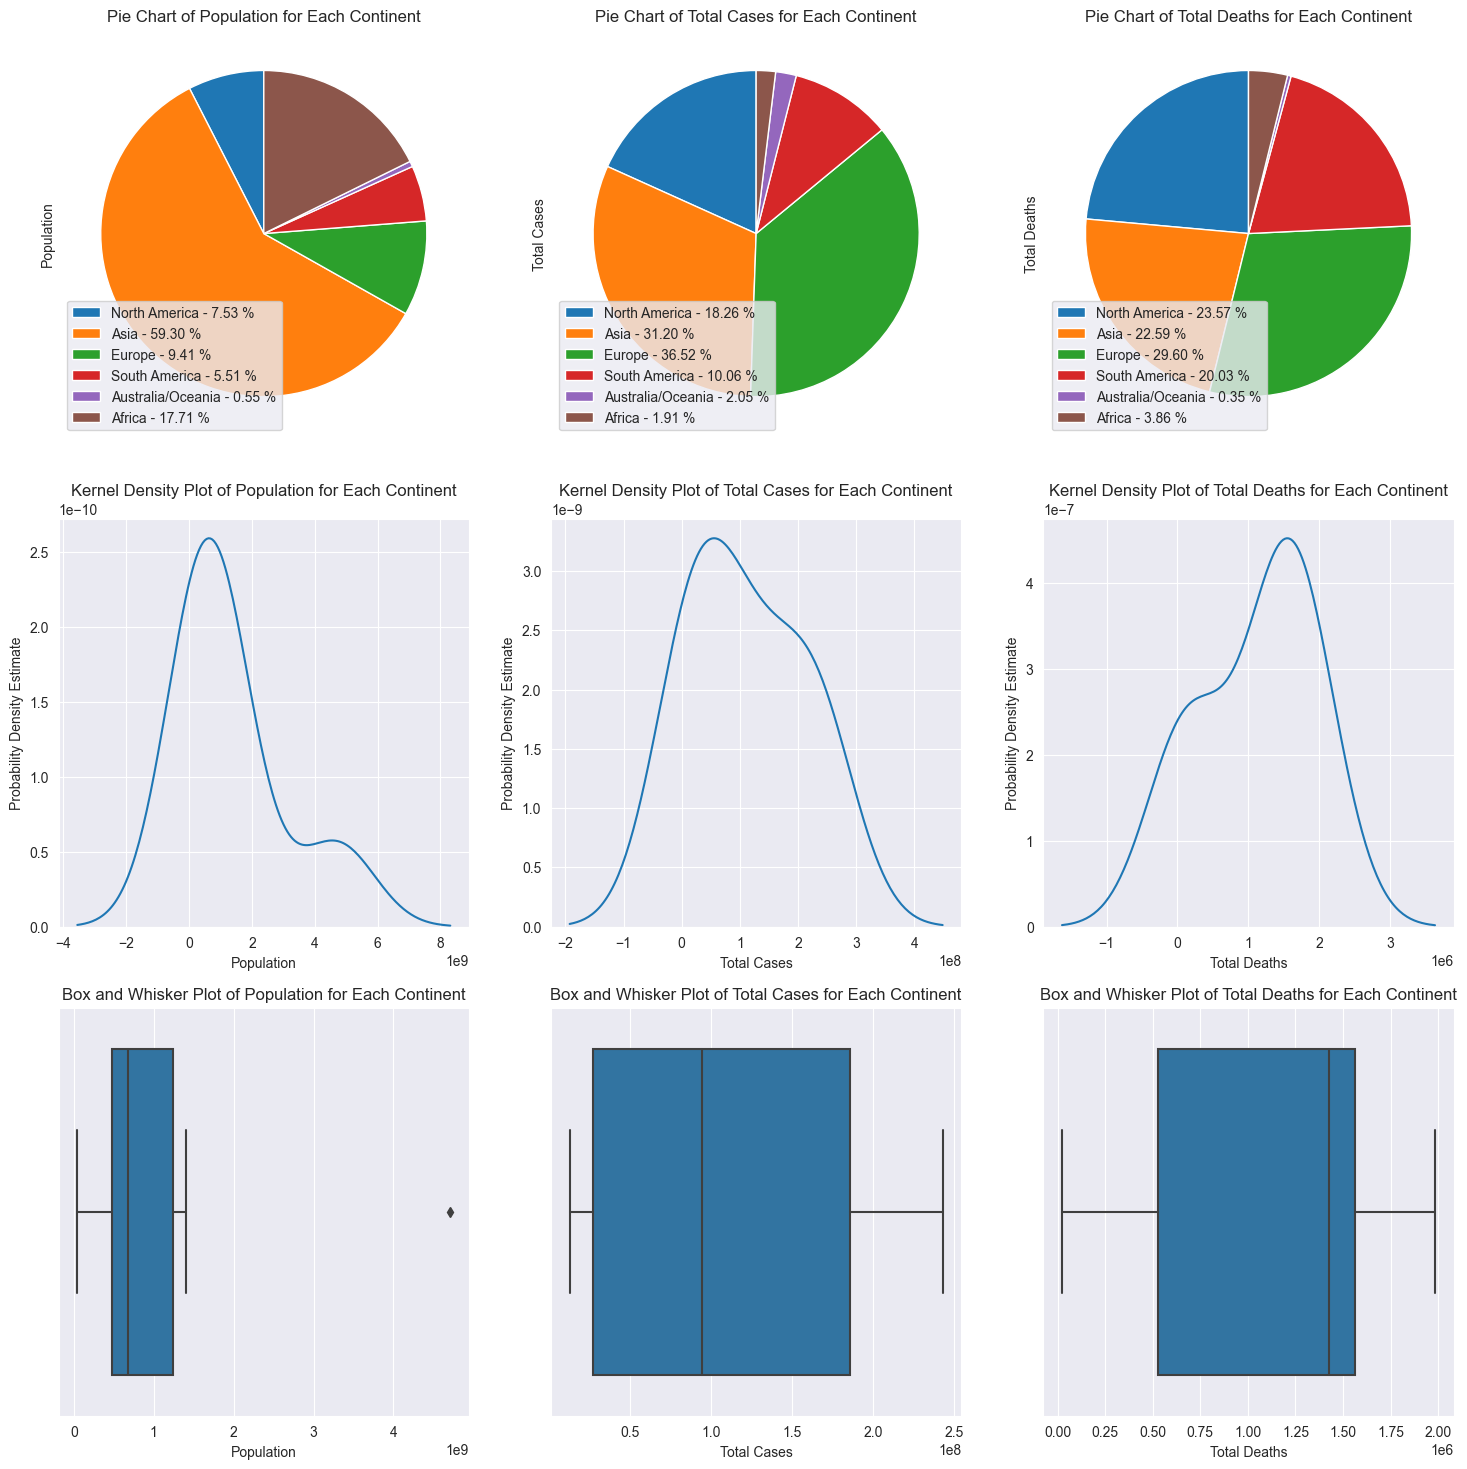

In [94]:
# Pie charts showing the share of population, total cases, and total deaths that each continent has
fig = plt.figure(figsize=(18, 18))  # Setting the figure size
plot_data = ["Population", "Total Cases", "Total Deaths"]  # List of the column titles we wish to plot
for i in range(3):  # Iterating through the column titles
    ax = plt.subplot(3, 3, 1 + i, aspect="equal")  # Defining the axis and position of the chart
    PC = df.loc[:"Africa"].plot(kind="pie", y=plot_data[i], ax=ax, startangle=90, shadow=False, labels=None)  # Plotting the desired data
    x = np.char.array(new_continent_list[:-1])  # Creating an array of continent names for the legend
    y = df[plot_data[i]].head(6)  # Creating an array of continent data for the legend
    percent = 100.*y/y.sum()  # Calculating the percentage for each continent
    label = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, percent)]  # Formattingg the x and y data into a string
    plt.legend(label)  # Defining the legend
    PC.set_title(f"Pie Chart of {plot_data[i]} for Each Continent")

for i in range(3):  # Iterating through the column titles
    ax = plt.subplot(3, 3, 4 + i)  # Defining the axis and position of the chart
    KDE = sns.kdeplot(data=df.loc[:"Africa"][plot_data[i]])
    KDE.set_title(f"Kernel Density Plot of {plot_data[i]} for Each Continent")
    KDE.set_ylabel("Probability Density Estimate")
    KDE.set_xlabel(plot_data[i])

for i in range(3):
    ax = plt.subplot(3, 3, 7 + i)
    #BWP = sns.boxplot(data=df.loc[:"Africa"][plot_data[i]])
    BWP = sns.boxplot(x=df.loc[:"Africa"][plot_data[i]])
    BWP.set_xlabel(plot_data[i])
    BWP.set_title(f"Box and Whisker Plot of {plot_data[i]} for Each Continent")

plt.show()  # Showing the figure

In [95]:
# Due the poisitive skew of these distributions it is worth calculating the central tendency of the distributions
df2 = DataFrame()
df2["Mean"] = df.loc["USA":].mean(numeric_only=True)
df2["Median"] = df.loc["USA":].median(numeric_only=True)
print(df2)

# Displaying descriptive statistics for Continents
df.loc[:"Africa"].describe()



                                  Mean        Median
Population                3.469404e+07  5.797805e+06
Total Cases               2.907302e+06  2.076540e+05
Total Deaths              3.004537e+04  2.230000e+03
Total Tests               3.233608e+07  2.213831e+06
Total Recovered           2.975462e+06  2.425435e+05
Active Cases              9.363030e+04  1.323000e+03
Critical Cases            3.001151e+02  2.000000e+01
Total Cases / 1M People   1.919278e+05  1.239749e+05
Total Deaths / 1M People  1.227811e+03  7.879186e+02
Total Tests / 1M People   2.112360e+06  8.845931e+05
One Case / n People       4.064610e+02  8.066150e+00
One Death / n People      1.456833e+04  1.269167e+03
One Test / n People       1.078349e+01  1.130463e+00
Active Cases / 1M People  1.494860e+04  5.497668e+02


,Population,Total Cases,Total Deaths,Total Tests,Total Recovered,Active Cases,Critical Cases,Total Cases / 1M People,Total Deaths / 1M People,Total Tests / 1M People,One Case / n People,One Death / n People,One Test / n People,Active Cases / 1M People
count,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000,6.000000,6.000000,6.000000e+00,6.000000,6.000000,6.000000,6.000000
mean,1.324156e+09,1.109620e+08,1.116686e+06,1.147931e+09,1.063097e+08,3.535632e+06,6952.666667,174723.751773,1567.174724,1.512534e+06,25.132285,1916.369797,2.974739,3737.788186
std,1.718458e+09,9.797112e+07,7.880664e+05,1.203710e+09,9.412282e+07,4.496110e+06,5310.867713,132474.013369,1349.438281,1.395164e+06,42.421966,2056.704762,4.873667,2314.310335
min,4.347041e+07,1.274280e+07,2.338900e+04,8.844953e+07,1.204085e+07,2.668790e+05,151.000000,9058.459248,183.649478,7.808319e+04,3.074575,326.085975,0.266209,315.344377
25%,4.778061e+08,2.697737e+07,5.293255e+05,1.426502e+08,2.614641e+07,6.103962e+05,2510.500000,71336.001690,375.456764,5.118441e+05,3.621472,377.396783,0.470683,2550.302810
50%,6.728424e+08,9.428108e+07,1.427921e+06,7.654283e+08,9.044724e+07,2.337892e+06,8654.000000,178156.348899,1589.343905,1.292745e+06,5.726391,1118.639495,1.153533,3678.416464
75%,1.241933e+09,1.861606e+08,1.563002e+06,2.085190e+09,1.745775e+08,3.617629e+06,10194.000000,286034.530336,2649.741553,2.125915e+06,18.645951,2799.196567,1.957314,5750.324886
max,4.711357e+09,2.431373e+08,1.983065e+06,2.808111e+09,2.375892e+08,1.219236e+07,13087.000000,325248.210159,3066.675900,3.756450e+06,110.394050,5445.155679,12.806854,6139.325860


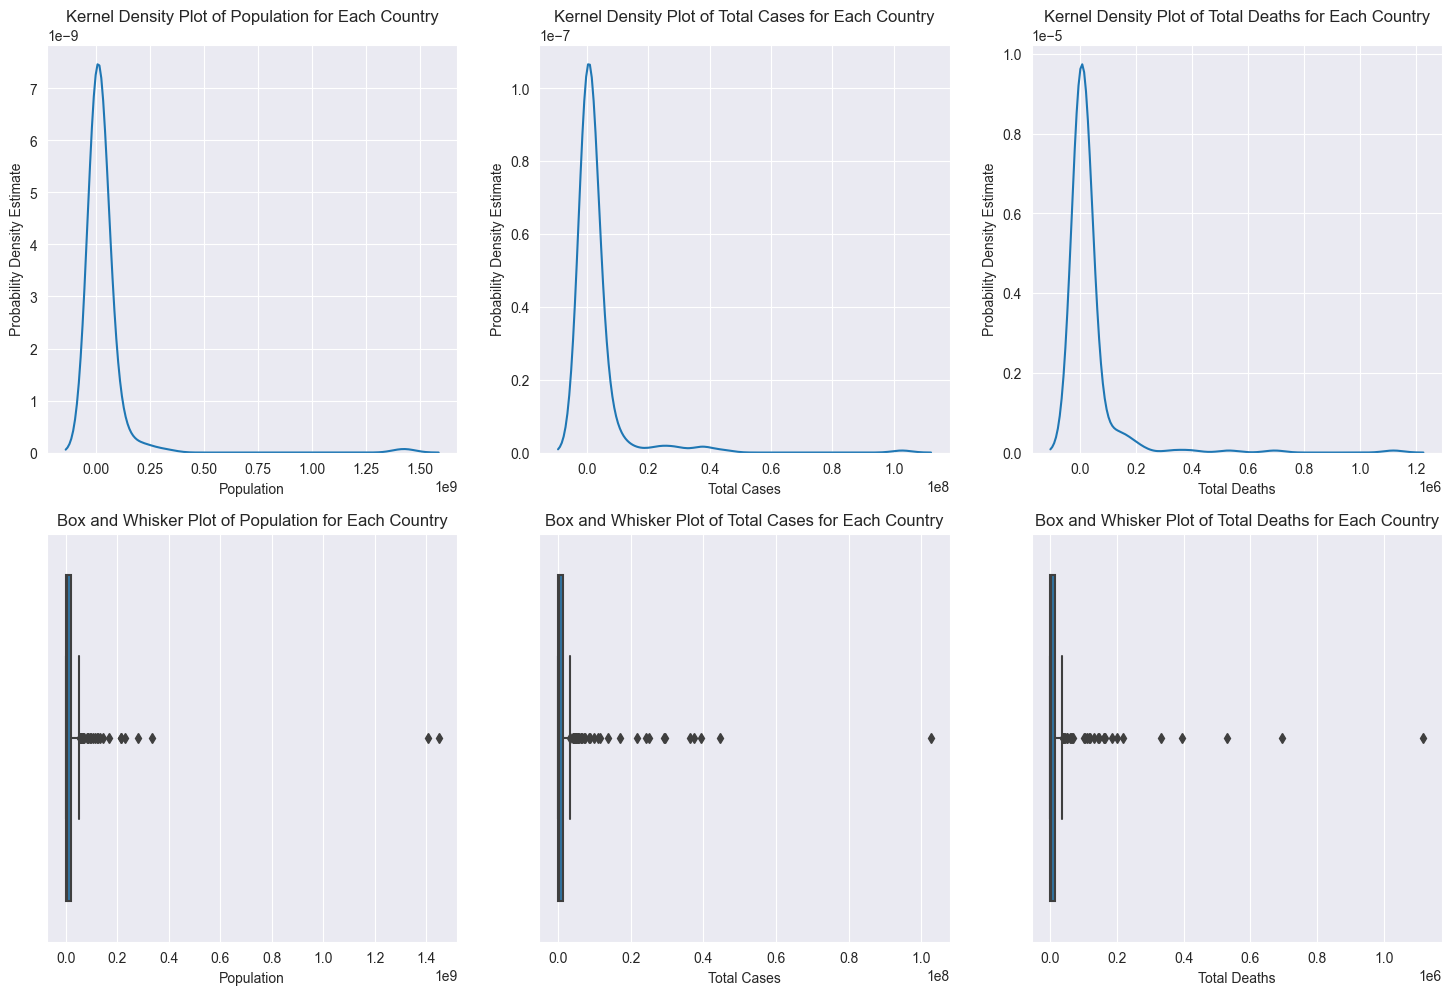

In [96]:
# Country Data Distributions
fig = plt.figure(figsize=(18, 18))  # Setting the figure size
plot_data = ["Population", "Total Cases", "Total Deaths"]  # List of the column titles we wish to plot
for i in range(3):  # Iterating through the column titles
    ax = plt.subplot(3, 3, 4 + i)  # Defining the axis and position of the chart
    KDE = sns.kdeplot(data=df.loc["USA":][plot_data[i]])
    KDE.set_title(f"Kernel Density Plot of {plot_data[i]} for Each Country")
    KDE.set_ylabel("Probability Density Estimate")
    KDE.set_xlabel(plot_data[i])

for i in range(3):
    ax = plt.subplot(3, 3, 7 + i)
    BWP = sns.boxplot(x=df.loc["USA":][plot_data[i]])
    BWP.set_xlabel(plot_data[i])
    BWP.set_title(f"Box and Whisker Plot of {plot_data[i]} for Each Country")

plt.show()

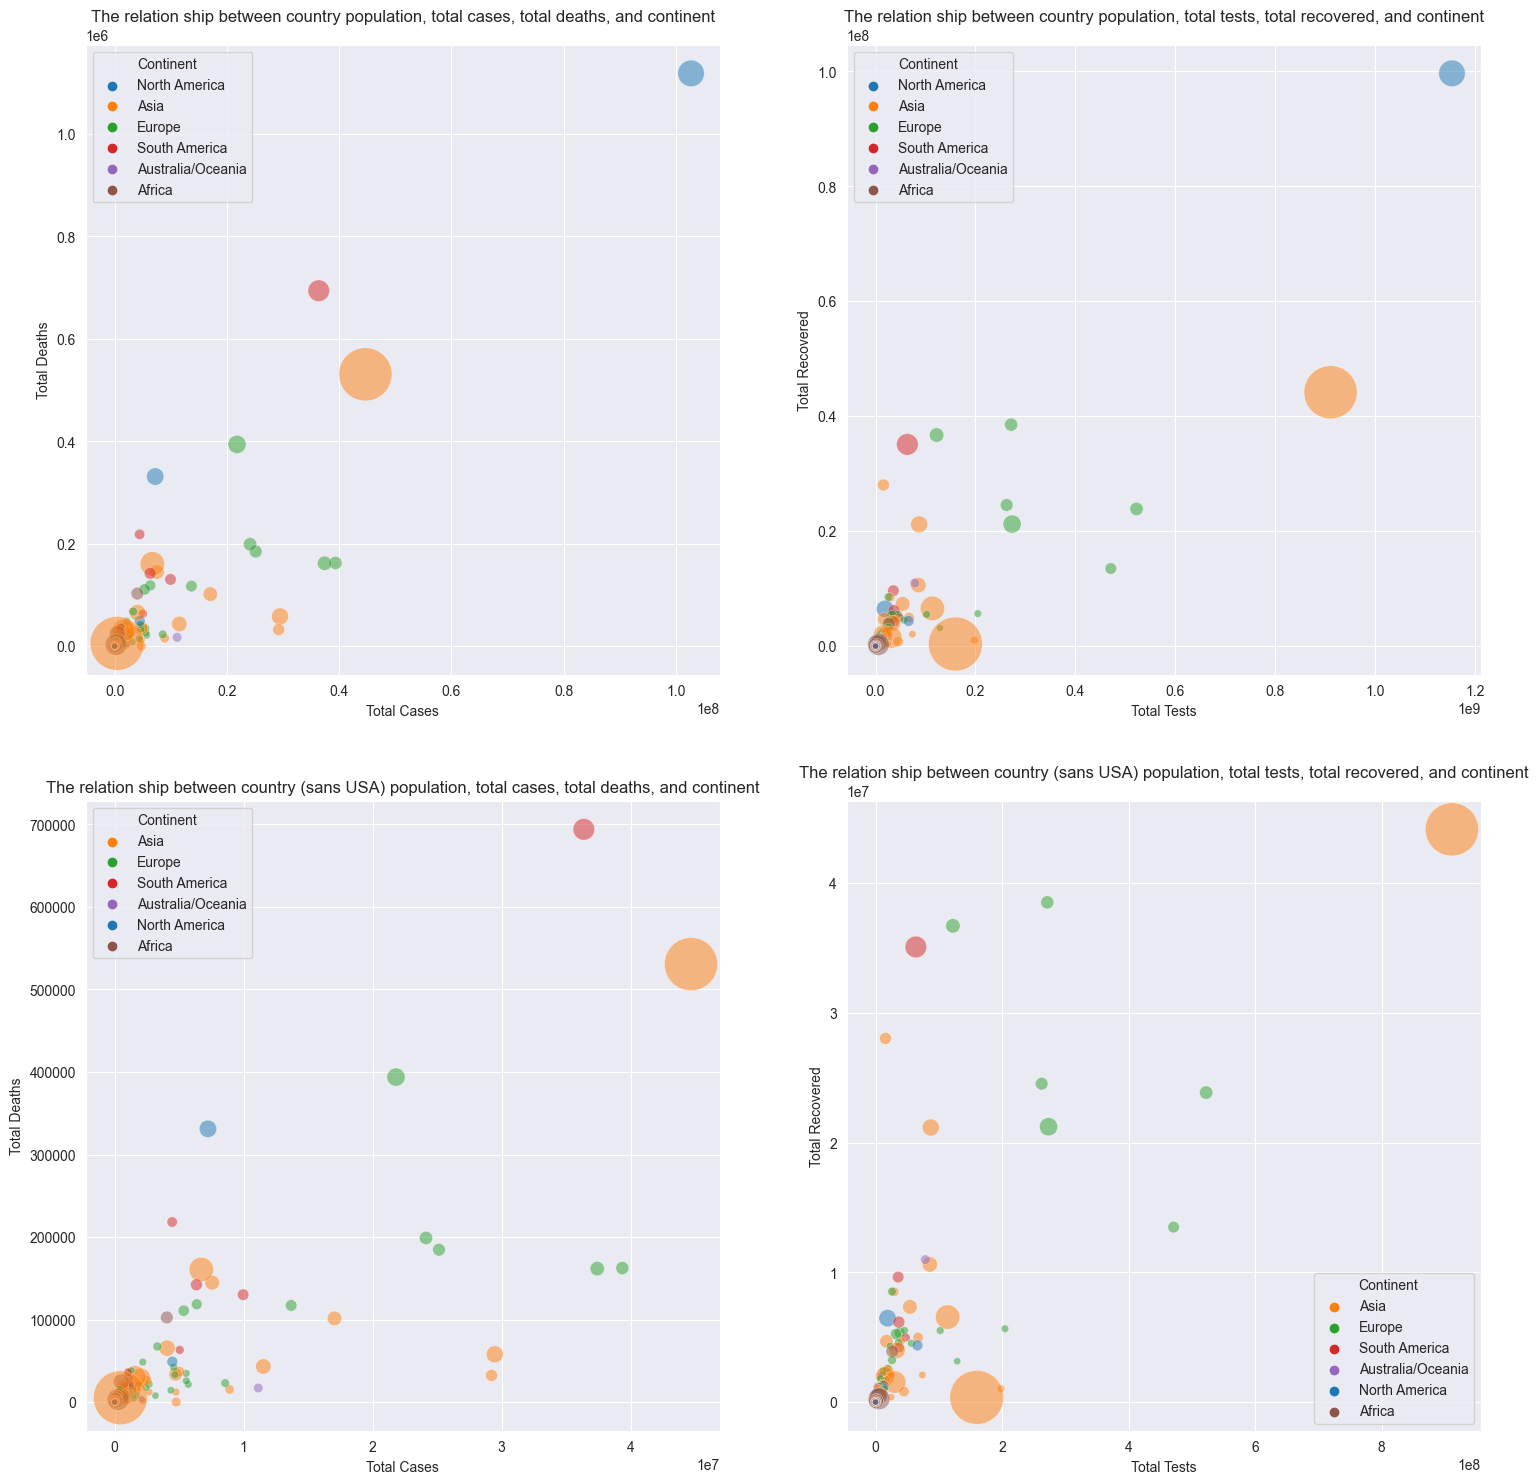

In [97]:
# Relationship between country population, total cases, total deaths, and continent
fig = plt.figure(figsize=(18, 18))
ax1 = plt.subplot(2, 2, 1)
BP1 = sns.scatterplot(data=df.loc["USA":], x="Total Cases", y="Total Deaths", size="Population", hue="Continent", palette=colour_dict,
                      sizes=(20,1500), alpha=0.5, legend=True)
h,l = BP1.get_legend_handles_labels()
plt.legend(h[0:7],l[0:7])
BP1.set_title("The relation ship between country population, total cases, total deaths, and continent")

# Relationship between country population, total tests, total recovered, and continent
ax2 = plt.subplot(2, 2, 2)
BP2 = sns.scatterplot(data=df.loc["USA":], x="Total Tests", y="Total Recovered", size="Population", hue="Continent", palette=colour_dict,
                      sizes=(20,1500), alpha=0.5, legend=True)
h,l = BP2.get_legend_handles_labels()
plt.legend(h[0:7],l[0:7])
BP2.set_title("The relation ship between country population, total tests, total recovered, and continent")

#
ax3 = plt.subplot(2, 2, 3)
BP3 = sns.scatterplot(data=df.loc["India":], x="Total Cases", y="Total Deaths", size="Population", hue="Continent", palette=colour_dict,
                      sizes=(20,1500), alpha=0.5, legend=True)
h,l = BP3.get_legend_handles_labels()
plt.legend(h[0:7],l[0:7])
BP3.set_title("The relation ship between country (sans USA) population, total cases, total deaths, and continent")

# Relationship between country population, total tests, total recovered, and continent
ax4 = plt.subplot(2, 2, 4)
BP4 = sns.scatterplot(data=df.loc["India":], x="Total Tests", y="Total Recovered", size="Population", hue="Continent", palette=colour_dict,
                      sizes=(20,1500), alpha=0.5, legend=True)
h,l = BP4.get_legend_handles_labels()
plt.legend(h[0:7],l[0:7])
BP4.set_title("The relation ship between country (sans USA) population, total tests, total recovered, and continent")

plt.show()

Step 4a: What are the outlier countries for total cases? (10%)

In [110]:
# Calculate the mean and standard deviation of the column
mean_total_cases = df.loc["USA":, "Total Cases"].mean()
std_total_cases = df.loc["USA":, "Total Cases"].std()

# Creating a boolean mask for the outliers using a bitwise OR to combine the two boolean masks into one
mask = ((df["Total Cases"] - mean_total_cases).abs() > 2 * std_total_cases) | (df.index.isin(new_continent_list))

# Getting the index of all the outlier values
outlier_countries_index = df.loc["USA":][mask].index

# Adding the index to a list of countries
outlier_countries = list(outlier_countries_index)
string = "The outlier countries for total Covid-19 cases are: " + ", ".join(map(str, outlier_countries))
print(string)
# Outlier countries are USA, India, France, Germany, Brazil, Japan, S. Korea, Italy, UK, and Russia
# It feels like China should be on here, the data set claims ~400k total cases for china while google suggests 1.9M. Google agrees with China total deaths however
df.loc[outlier_countries]

# What is common among them
# They are all members of the united nations, they are among the most populous countries in the world, and they are all considered to be major econmic powers either as developed countries or emerging markets.

# Outliers for GDP

# Is this also the case for total tests/deaths

The outlier countries for total Covid-19 cases are: USA, India, France, Germany, Brazil, Japan, S. Korea, Italy, UK, Russia


C:\Users\misha\AppData\Local\Temp\ipykernel_11240\3422732844.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outlier_countries_index = df.loc["USA":][mask].index


,Continent,GDP (USD million),Population,Total Cases,Total Deaths,Total Tests,Total Recovered,Active Cases,Critical Cases,Total Cases / 1M People,Total Deaths / 1M People,Total Tests / 1M People,One Case / n People,One Death / n People,One Test / n People,Active Cases / 1M People
Country,,,,,,,,,,,,,,,,
USA,North America,20893746,3.348053e+08,102692125.0,1118490.0,1.153934e+09,99620490.0,1953145.0,4597.0,306721.950066,3340.718034,3.446583e+06,3.260282,299.336846,0.290142,5833.674619
India,Asia,2664749,1.406632e+09,44680261.0,530707.0,9.109238e+08,44145667.0,3887.0,698.0,31764.006588,377.289216,6.475922e+05,31.482175,2650.486570,1.544182,2.763339
France,Europe,2630318,6.558452e+07,39356184.0,162377.0,2.714902e+08,38520768.0,673039.0,869.0,600083.452622,2475.843460,4.139547e+06,1.666435,403.902757,0.241572,10262.162787
Germany,Europe,3846414,8.388360e+07,37410650.0,161714.0,1.223324e+08,36710000.0,538936.0,1406.0,445982.907075,1927.838191,1.458359e+06,2.242238,518.715733,0.685702,6424.808016
Brazil,South America,1444733,2.153536e+08,36371609.0,694032.0,6.377617e+07,35081933.0,595644.0,8318.0,168892.510653,3222.755610,2.961463e+05,5.920926,310.293463,3.376710,2765.888378
Japan,Asia,5057759,1.255848e+08,29467627.0,57944.0,8.729496e+07,21165460.0,8244223.0,602.0,234643.189969,461.393277,6.951075e+05,4.261790,2167.348440,1.438626,65646.642790
S. Korea,Asia,1637896,5.132990e+07,29220591.0,32301.0,1.580406e+07,28030407.0,1157883.0,620.0,569270.377875,629.282360,3.078920e+05,1.756635,1589.111761,3.247892,22557.671504
Italy,Europe,1888709,6.026277e+07,25143705.0,184642.0,2.625587e+08,24541402.0,417661.0,314.0,417234.471631,3063.948106,4.356898e+06,2.396734,326.376285,0.229521,6930.663824
UK,Europe,2764198,6.849791e+07,24135084.0,198937.0,5.225265e+08,23854762.0,81385.0,146.0,352347.758596,2904.278521,7.628357e+06,2.838105,344.319594,0.131090,1188.138493


Step 4b: Question 2 (10%)

In [ ]:
# What role does GDP play in the total deaths

# Does this role extend to what fraction of people died

Step 4c: Question 3 (10%)

Step 5: Summary and Conclusion (5%)

Write summary/conc in here